In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import StatePreparation, RYGate
from qiskit.quantum_info import Statevector
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from tqdm import tqdm


from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
nx = 4
n = 2

xmax=8.
xmin=0.

nintx = int(np.ceil(np.log2((xmax-xmin))))
npresx = nx - nintx - 1

In [4]:
ls = 1.
sig = np.sqrt(2.)
noise_std = .75

In [5]:
def y_targ(x):
    y_ = np.squeeze(x * np.sin(x))#/4
    return y_

In [6]:
X = np.linspace(start=xmin, stop=xmax, num=2**nx).reshape(-1, 1)
y = y_targ(X)

In [7]:
X_train = np.linspace(start=xmin, stop=xmax, num=2**n).reshape(-1, 1)
y_train = y_targ(X_train)

In [8]:
def SEK(X1, X2, ls=1.0, sig=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sig * np.exp(-0.5 / ls**2 * sqdist)

In [9]:
def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = SEK(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = SEK(X_train, X_s, l, sigma_f)
    K_ss = SEK(X_s, X_s, l, sigma_f)
    K_inv = np.linalg.inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [10]:
mean_prediction, cov_s = posterior(X, X_train, y_train, l=ls, sigma_f=sig, sigma_y=noise_std)
std_prediction = np.sqrt(np.diag(cov_s))

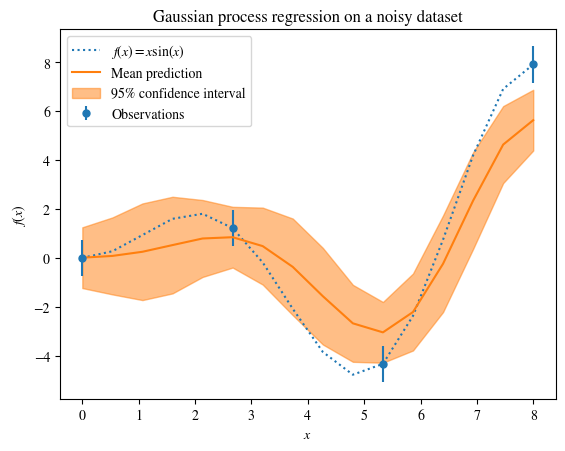

In [11]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [12]:
u_ind = (len(X)//2) - 1

v = y_train
u = SEK(X, X_train, ls, sig=sig)[u_ind]

v_norm = np.sqrt(np.sum(np.abs(v)**2))
u_norm = np.sqrt(np.sum(np.abs(u)**2))

v_ = v/v_norm
u_ = u/u_norm

In [13]:
A = SEK(X_train, X_train, ls, sig=sig) + (np.eye(len(X_train))*noise_std**2)

In [14]:
print(A)

[[1.97671356e+00 4.03977186e-02 9.41634509e-07 1.79098347e-14]
 [4.03977186e-02 1.97671356e+00 4.03977186e-02 9.41634509e-07]
 [9.41634509e-07 4.03977186e-02 1.97671356e+00 4.03977186e-02]
 [1.79098347e-14 9.41634509e-07 4.03977186e-02 1.97671356e+00]]


In [15]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [16]:
neg_vals = True

kappa = np.linalg.cond(A)
lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))

nanc = np.max([int(np.log2(A.shape[0])) + 1, int(np.ceil(np.log2(kappa + 1)))]) + neg_vals
nanc = nanc * 2

scaling = get_delta(nanc - neg_vals, lambda_min, lambda_max)
t = 2 * np.pi * scaling / lambda_min / (2**neg_vals)

print(t, scaling, nanc, kappa, noise_std**2, lambda_min, lambda_max)

1.5152412957414507 0.921875 8 1.0683965763734633 0.5625 1.9113495227906385 2.042079286402571


In [17]:
qcont = QuantumRegister(1, 'cont')
qtarg = QuantumRegister(1, 'targ')
qreg = QuantumRegister(n, 'reg')
qanc = QuantumRegister(nanc, 'anc')

circ = QuantumCircuit(qanc, qtarg, qreg, qcont)

In [18]:
circ.h(qcont);

In [19]:
prepv_gate = StatePreparation(Statevector(v_)).control(1)
circ.append(prepv_gate, [qcont, *qreg]);

In [20]:
circ.x(qcont);
circ.cx(qcont, qtarg);
prepu_gate = StatePreparation(Statevector(u_)).control(1)
circ.append(prepu_gate, [qcont, *qreg]);
circ.x(qcont);

In [21]:
hhl_gate = qt.HHL(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling, wrap=True).control(1)
circ.append(hhl_gate, [qcont, *qreg, *qanc, qtarg]);

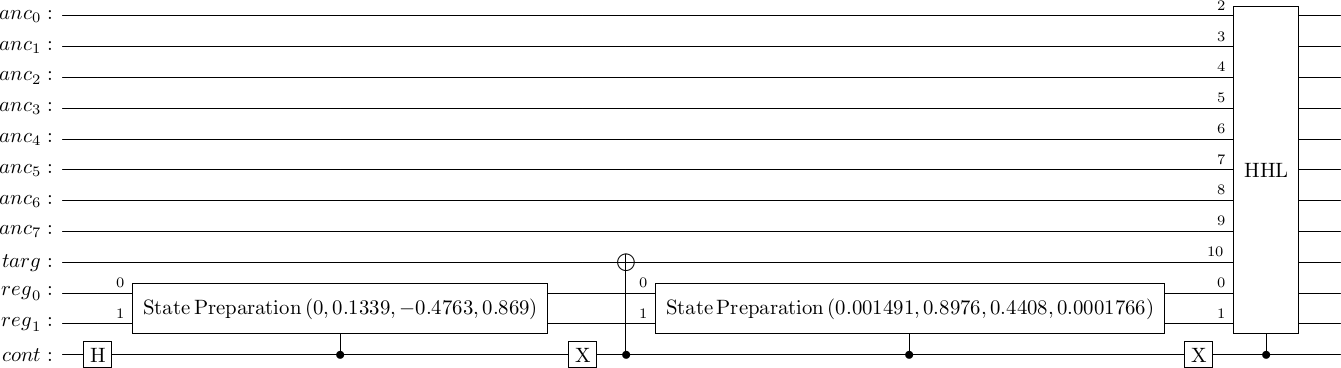

In [22]:
circ.draw('latex')

In [23]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [24]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [25]:
norm_ = np.sqrt(np.sum(np.abs(state_v[:,1])**2))

In [26]:
state_v = state_v[0,1,:,1].real

In [27]:
targ_v = np.matmul(np.linalg.inv(A),v_)

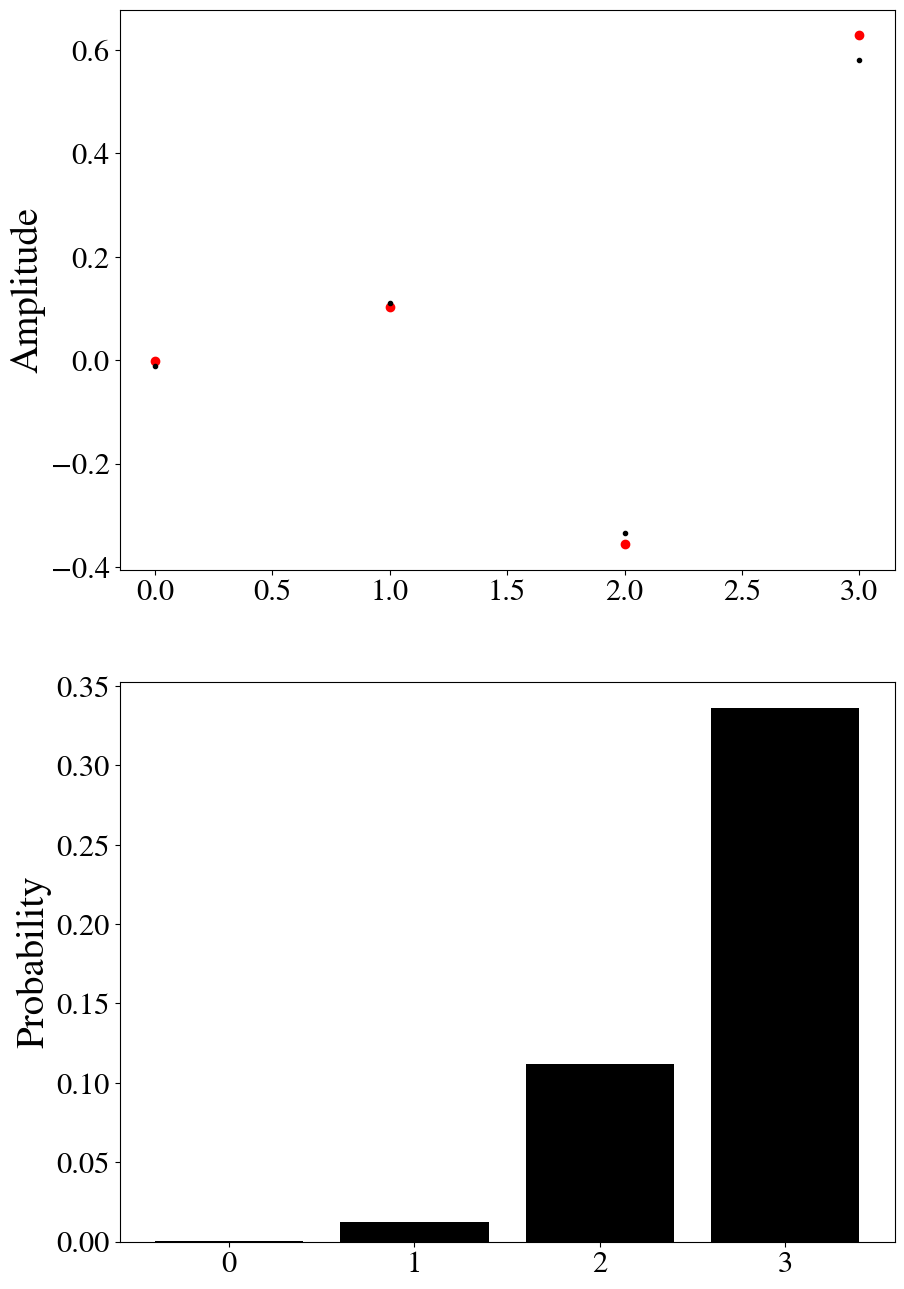

In [28]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(np.arange(2**n), targ_v*np.sqrt(2.), marker='o', color='red')
plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.bar(np.arange(2**n), np.abs(state_v)**2, color='black')
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [29]:
state_v = state_v.real/np.sqrt(np.sum(np.abs(state_v)**2))
norm = norm_/lambda_min
out = state_v*norm

In [30]:
print(out, targ_v, out/targ_v)

[-0.00821369  0.08495899 -0.25512753  0.44164053] [-0.00148979  0.07290306 -0.25152487  0.44477957] [5.5133367  1.16536938 1.01432328 0.99294248]


In [31]:
state_u = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [32]:
state_u = state_u[0,1,:,0].real

In [33]:
state_u = state_u.real/np.sqrt(np.sum(np.abs(state_u)**2))

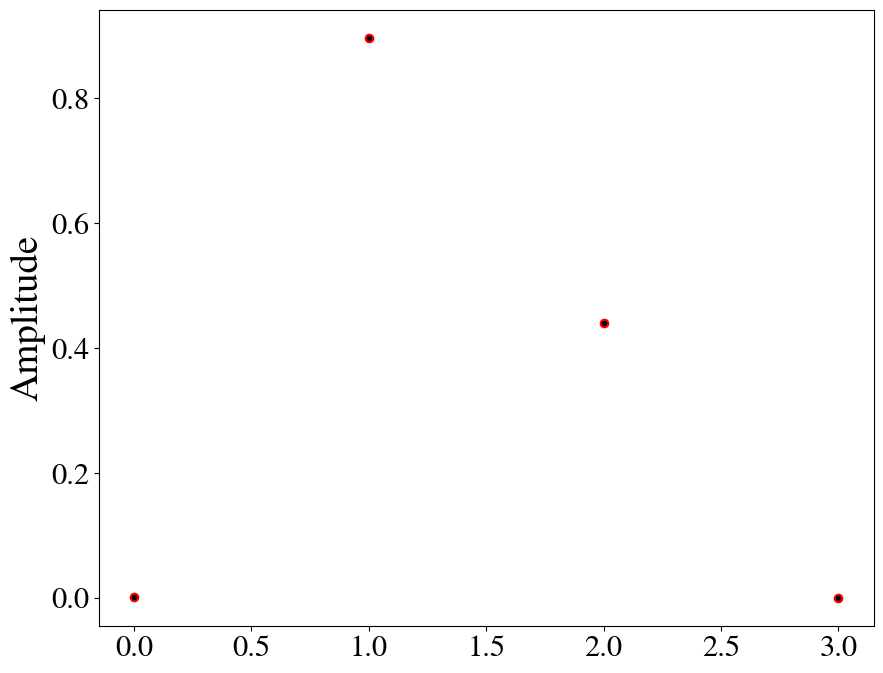

In [34]:
fig = plt.figure(figsize=np.array(figsize))
ax = fig.add_subplot(111)

plt.scatter(np.arange(2**n), u_, marker='o', color='red')
plt.scatter(np.arange(2**n), state_u.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [35]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [36]:
state_v = state_v[0,1].T

In [37]:
X_matrix = np.array([[0,1],[1,0]])

In [38]:
QGPR_out = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2.))
target = mean_prediction[u_ind]

In [39]:
print(QGPR_out, target)

-0.35520960244856553 -0.3685088859567512


In [40]:
mus = []
stds = []

for i in tqdm(np.arange(2**nx)):
    
    v = y_train
    u = SEK(X, X_train, ls, sig=sig)[i]

    v_norm = np.sqrt(np.sum(np.abs(v)**2))
    u_norm = np.sqrt(np.sum(np.abs(u)**2))

    v_ = v/v_norm
    u_ = u/u_norm
    
    v_gate = StatePreparation(Statevector(v_))
    u_gate = StatePreparation(Statevector(u_))

    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, v_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    mus.append(np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2)))
    
    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, u_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    M_exp = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*((u_norm**2)*scaling/np.sqrt(2))

    stds.append(SEK(X, X, ls, sig=sig)[i,i]-M_exp)
    
mus = np.array(mus)
stds = np.array(stds)

100%|███████████████████████████████████████████| 16/16 [02:09<00:00,  8.10s/it]


Text(0, 0.5, '$f(x)$')

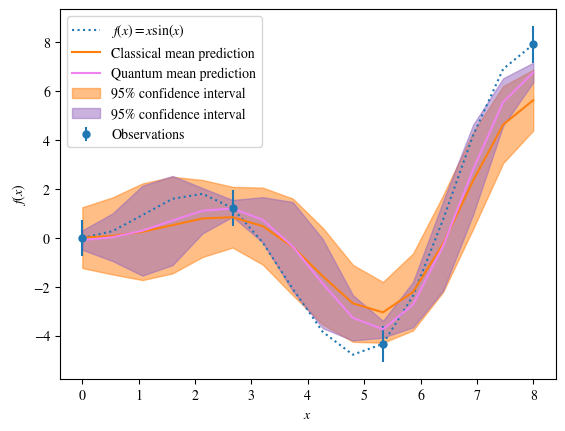

In [41]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Classical mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.plot(X, mus, color='violet', label="Quantum mean prediction")
plt.fill_between(
    X.ravel(),
    mus - 1.96 * stds,
    mus + 1.96 * stds,
    color="tab:purple",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")